### Install Segment Anything Model (SAM) and other **dependencies**

In [1]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget dataclasses-json supervision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-f90jtkh3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-f90jtkh3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=471bc7be846e8e8f0461071647ca3ff680978d17344d4185882c36d880a41fec
  Stored in directory: /tmp/pip-ephem-wheel-cache-f6m8w1_8/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━

### Clone and install the dependencies for Grounding DINO

In [2]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q dataclasses-json onemetric

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 273 (delta 20), reused 18 (delta 16), pack-reused 226
Receiving objects: 100% (273/273), 12.34 MiB | 10.17 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/GroundingDINO
Branch 'feature/more_compact_inference_api' set up to track remote branch 'feature/more_compact_inference_api' from 'origin'.
Switched to a new branch 'feature/more_compact_inference_api'
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.6 MB/s eta 0:00:00


### Download SAM weights

In [3]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

### Download Grounding DINO weights

In [4]:
# download weights file
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

### Import the required libraries

In [5]:
import torch
import os
import supervision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from groundingdino.util.inference import Model
%matplotlib inline

## Load Models

In [6]:
#Check if GPU is available.
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Load the SAM model.
CHECKPOINT_PATH_SAM ='/content/GroundingDINO/sam_vit_h_4b8939.pth'
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH_SAM).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

#Load the Grounding DINO model.
WEIGHTS_PATH_GDINNO = "/content/GroundingDINO/groundingdino_swint_ogc.pth"
CONFIG_PATH = "/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH_GDINNO)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Perform the object detection

In [26]:
#Source image path and other hyperparameters.
SOURCE_IMAGE_PATH = f"/content/apple.jpg"
CLASSES = ['apple']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

In [27]:
#Performing detection with Grounding DINO.
image = cv2.imread(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

detections_dino, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


### Generate masks with SAM

In [28]:
#Annotate for all occurances.

image_bgr = cv2.imread('/content/apple.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
seg_mask=np.zeros_like(image_rgb)
pred_mask_list=[]

for i in range(detections_dino.xyxy.shape[0]):
  box=detections_dino.xyxy[i]
  mask_predictor.set_image(image_rgb)

  masks, scores, logits = mask_predictor.predict(
      box=box,
      multimask_output=True
  )

  masks=np.transpose(masks,[2,1,0])
  masks=np.transpose(masks,[1,0,2])

  pred_mask_list.append(masks)

#Setting all the masks places to 255.

for i in range(len(pred_mask_list)):
  seg_mask[pred_mask_list[i]]=255


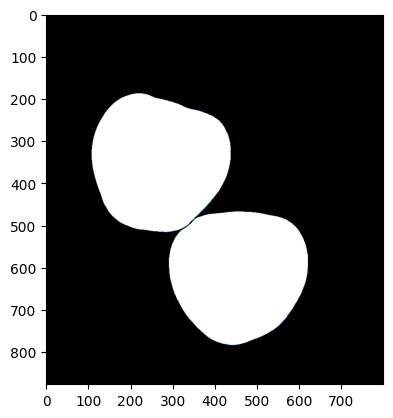

In [29]:
#Visualize the generated mask.
plt.imshow(seg_mask)